In [1]:
import glob
import matplotlib.pyplot as plt
import os
import re
import pandas
from pandas import DataFrame
from pathlib import Path
import scyjava
import seaborn
import tkinter as tk
from tkinter import filedialog, simpledialog, messagebox
import csv
import numpy as np
from skimage.measure import find_contours, label

# test graph 

In [6]:
def define_main_path():
    # Dialog window to get the path of the working directory
    root = tk.Tk()
    root.withdraw()
    # Set the path to the directory containing the images
    directory_path = filedialog.askdirectory()
    return directory_path

def transpose_dataframe(df, x_dim):
    df_transposed = df.transpose()
    df_cleaned = df_transposed.drop(["time"])
    for i in range(0, len(df)):
        x_value = df["time"][i]
        df_cleaned.rename(columns={df_cleaned.columns[i]: f'{x_value}h'}, inplace=True)
    return df_cleaned

def choose_conditions(df):
    # Extract condition base names from columns that match *_exp
    condition_bases = sorted({col.split('_exp')[0] for col in df.columns if '_exp' in col})

    selected = []

    def on_select():
        nonlocal selected
        selected = [cond for cond, var in zip(condition_bases, varlist) if var.get()]
        win.destroy()

    win = tk.Tk()
    win.title("Select Conditions")
    tk.Label(win, text="Select conditions to plot:").pack()

    varlist = []
    for cond in condition_bases:
        var = tk.BooleanVar()
        tk.Checkbutton(win, text=cond, variable=var).pack(anchor="w")
        varlist.append(var)

    tk.Button(win, text="OK", command=on_select).pack()
    win.mainloop()
    return selected


def plot_mean_se_dots(df, save_dir, selected_conditions, time_col='time'):
    plt.figure(figsize=(6, 4))
    
    time = df[time_col]
    palette = seaborn.color_palette("Set2", len(selected_conditions))

    for i, cond in enumerate(selected_conditions):
        cond_cols = [col for col in df.columns if cond in col]
        cond_data = df[cond_cols]

        mean = cond_data.mean(axis=1)
        se = cond_data.sem(axis=1)

        plt.plot(time, mean, label=cond, color=palette[i], linewidth=2)
        plt.scatter(time, mean, color=palette[i], s=50, edgecolor='black', zorder=3)
        plt.errorbar(time, mean, yerr=se, fmt='none', ecolor=palette[i], elinewidth=1.5, capsize=5, capthick=1.5)

    plt.title("Colocalization over Time")
    plt.xlabel("Time (h)")
    plt.ylabel("% Colocalization")
    plt.ylim(0, df.drop(columns=[time_col]).max().max() * 1.2)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save outputs
    tif_path = os.path.join(save_dir, "coloc.tif")
    svg_path = os.path.join(save_dir, "coloc.svg")
    plt.savefig(tif_path)
    plt.savefig(svg_path)
    plt.show()

In [3]:
directory_path = define_main_path()

In [4]:
df_path = f"{directory_path}/quantif_coloc.csv"
df = pandas.read_csv(df_path)

In [5]:
x_dim = f"time"
df_transposed = transpose_dataframe(df, x_dim)
df_transposed.head()

,1h,6h,20h
OSBP+_exp1,5.726257,11.208150,4.285714
OSBP+_exp2,9.689922,13.011150,7.509881
OSBP+_exp3,7.476636,11.325300,12.056740
LC3+_exp1,14.106150,6.259098,1.587302
LC3+_exp2,8.527132,4.460967,1.976285


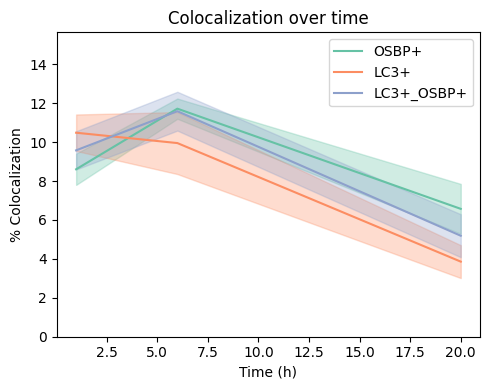

In [9]:
plot_mean_se_curves(df, directory_path, conditions_base=['OSBP+', 'LC3+', 'LC3+_OSBP+'], time_col='time')

In [ ]:
conditions = choose_conditions(df)
if conditions:
    plot_mean_se_dots(df, directory_path, conditions)
else:
    print("No conditions selected.")